In [2]:
#@title Import required library
from IPython.display import clear_output
if 'google.colab' in str(get_ipython()):
  !pip install talib-binary
  !pip install yfinance
  !pip install yahoo-fin
  !git clone https://github.com/PeemapatW/backtesting.py_FL.git
  %cd /content/backtesting.py_FL/backtesting
else:
  %cd D:/GitHub/backtesting.py_FL/backtesting

from IPython.display import clear_output
import json
import requests
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance
from tqdm import tqdm
from backtesting import Backtest, Strategy
from lib import crossover, cross, plot_heatmaps
import talib as ta
from strategy import *
from util import *
from ipywidgets import widgets
from bokeh.io import output_notebook
from matplotlib import colors
clear_output()

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Compare on diffent interval


Creating a contour plot of ROI% from trading BTC with EMA cross strategy (all in both on direction of signal) with different fast and slow period of EMA. The constraint of the backtesting is as follow: 
* Initial capital : 1,000,000$
* Commission rate : 0.1%
---
<font color='green'> Green </font> = Strategy Return - Hold Return > 0 | Return of using this trading strategy is greater than Buy&Hold 

<font color='yellow'> Yellow </font>= Strategy Return - Hold Return ~ 0 | Return of this using trading strategy is equal to Buy&Hold 

<font color='red'>  Red </font> = Strategy Return - Hold Return < 0 | Return of using this trading strategy is less than Buy&Hold

,Close,High,Low,Open
t,,,,
2010-07-17,0.049510,0.04951,0.04951,0.04951
2010-07-18,0.085840,0.08585,0.05941,0.05941
2010-07-19,0.080800,0.09307,0.07855,0.09090
2010-07-20,0.074733,0.08181,0.07426,0.08181
2010-07-21,0.079210,0.07921,0.06634,0.07425


D:\GitHub\backtesting.py_FL\backtesting\backtesting.py:1520: UserWarning: Searching for best of 780 configurations.
  output = _optimize_grid()


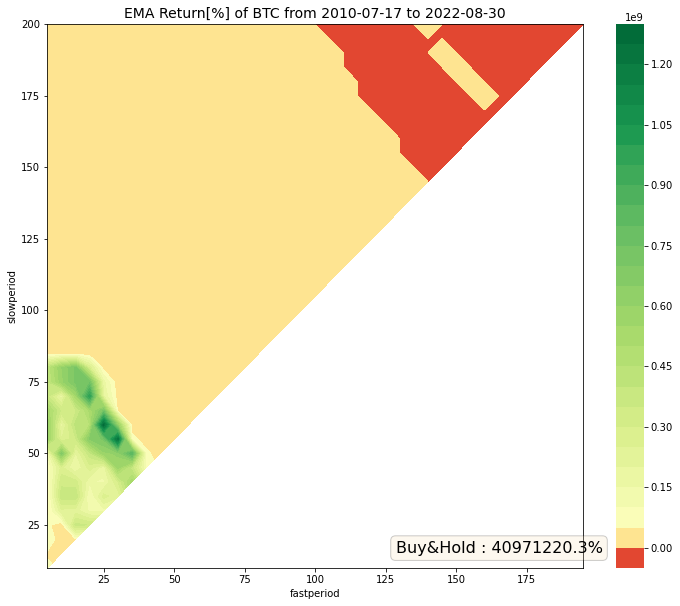

In [91]:
#@title 2010-07-17 to 2022-08-30 (12yrs)
import time
import datetime

def str_to_unix(strtime):
  return int(time.mktime(datetime.datetime.strptime(strtime, '%d/%m/%y %H:%M:%S').timetuple()))

params = {'a': 'BTC', 's':str_to_unix('17/07/10 00:00:00'), 'u':str_to_unix('31/08/22 00:00:00'), 'i':'24h', 'api_key': '2DTcBg9x0YgVPwieR9fybZAlGoA'}
read_data = pd.read_json(requests.get("https://api.glassnode.com/v1/metrics/market/price_usd_ohlc",params=params).text, convert_dates=['t']).set_index('t')
df = pd.DataFrame([[data['c'],data['h'],data['l'],data['o']] for data in read_data['o'].values],columns=['Close','High','Low','Open'],index=read_data.index)
display(df.head())
bt_full = Backtest(df, EMA_Cross, cash=1000000, commission=0.001)
eval_str = "bt_full.optimize("+opt_param_dict_to_eval_str(param,constraint)+",method=\"grid\",maximize=\"Return [%]\",return_heatmap=True)"
output = eval(eval_str)

#Output
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from 2010-07-17 to 2022-08-30'
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

In [97]:
#@title EMA with period (25,60)
bt_full.plot()
output_notebook()

Loading BokehJS ...

In [98]:
#@title 
bt_full._results

Start                              2010-07-17 00:00:00
End                                2022-08-29 00:00:00
Duration                            4426 days 00:00:00
Exposure Time [%]                            98.102553
Equity Final [$]                   12605699248459.0...
Equity Peak [$]                    12728069078582.6...
Return [%]                           1260569824.845907
Buy & Hold Return [%]                  40971220.301071
Buy & Hold Return [%] with open        40971220.301071
DCA Return [%]                           962726.509476
Return (Ann.) [%]                           284.974426
Volatility (Ann.) [%]                       544.456022
Sharpe Ratio                                  0.523411
Sortino Ratio                                 5.341239
Calmar Ratio                                  4.049336
Max. Drawdown [%]                           -70.375595
Avg. Drawdown [%]                           -11.526306
Max. Drawdown Duration               737 days 00:00:00
Avg. Drawd

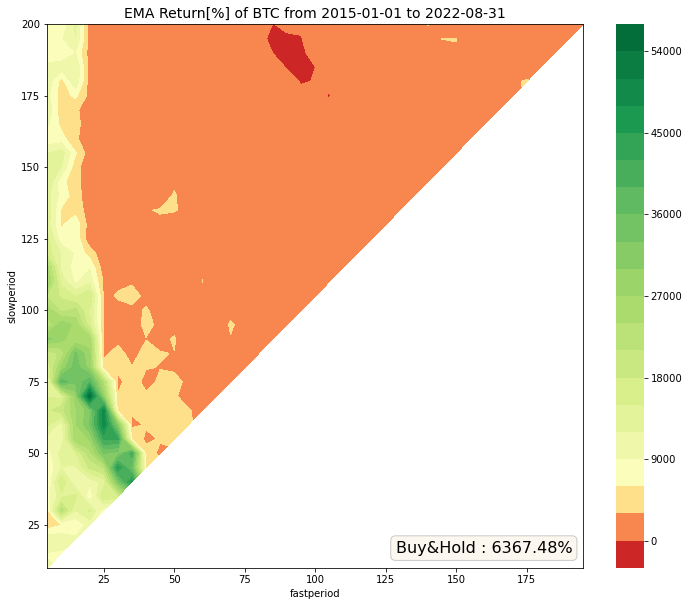

In [5]:
#@title 2015-01-01 to 2022-08-31 (7.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2022-08-31"
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

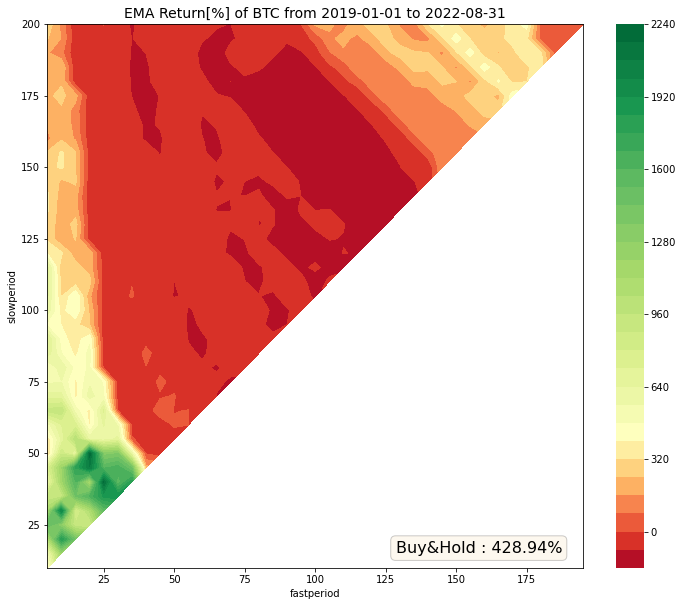

In [7]:
#@title 2019-01-01 to 2022-08-31 (3.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2019-01-01" 
end_date = "2022-08-31"
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

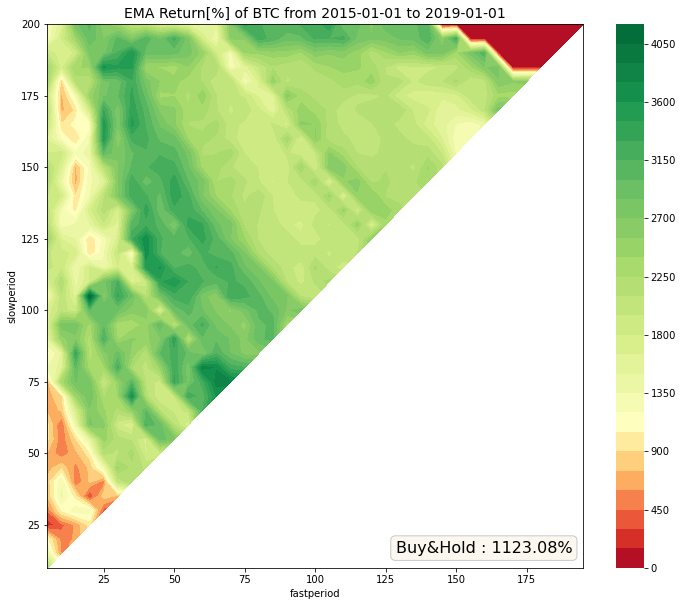

In [8]:
#@title 2015-01-01 to 2019-01-01 (4yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2019-01-01"
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

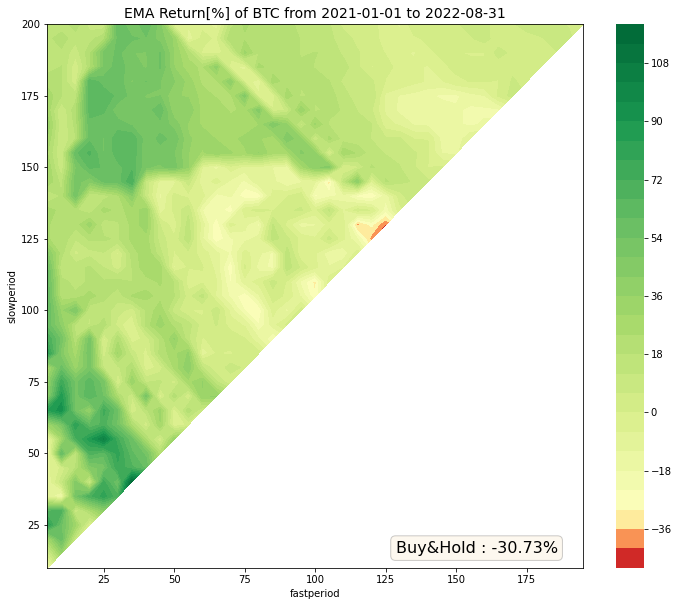

In [13]:
#@title 2021-01-01 to 2022-08-31 (1.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2021-01-01" 
end_date = "2022-08-31"
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

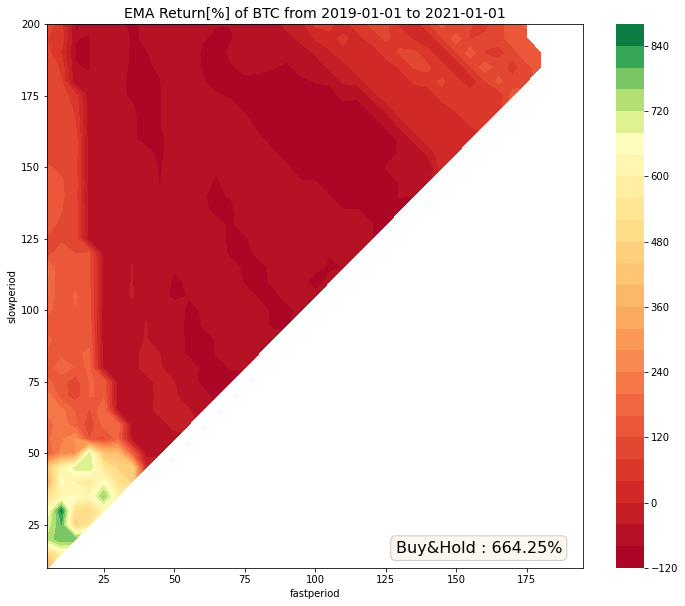

In [10]:
#@title 2019-01-01 to 2021-01-01 (2yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2019-01-01" 
end_date = "2021-01-01" 
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

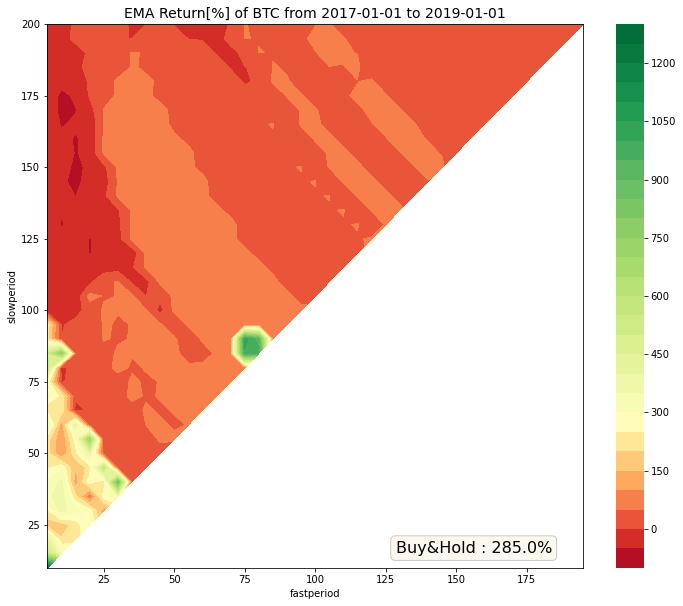

In [11]:
#@title 2017-01-01 to 2019-01-01 (2yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2017-01-01" 
end_date = "2019-01-01" 
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

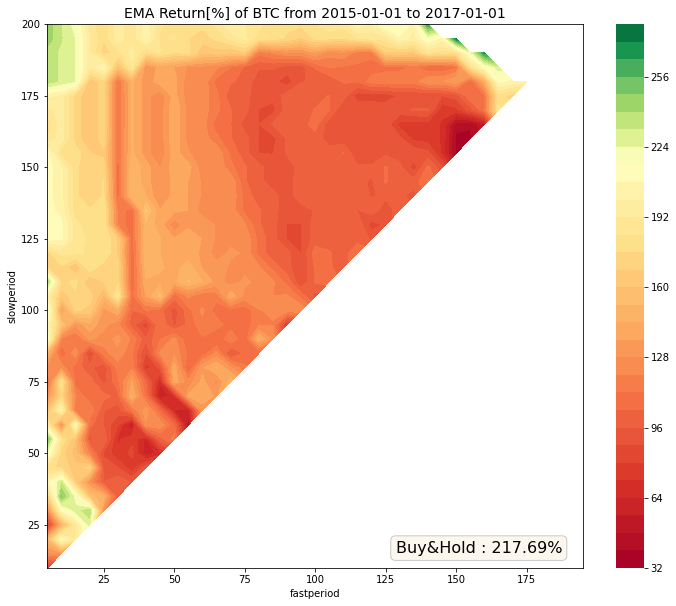

In [12]:
#@title 2015-01-01 to 2017-01-01 (2yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2017-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

# Fix startdate

Creating a contour plot of ROI% from trading BTC with EMA cross strategy (all in both on direction of signal) with different fast and slow period of EMA. The constraint of the backtesting is as follow:
* Initial capital : 1,000,000$
* Commission rate : 0.1%
---
<font color='green'> Green </font> = Strategy Return - Hold Return > 0 | Return of using this trading strategy is greater than Buy&Hold 

<font color='yellow'> Yellow </font>= Strategy Return - Hold Return ~ 0 | Return of this using trading strategy is equal to Buy&Hold 

<font color='red'>  Red </font> = Strategy Return - Hold Return < 0 | Return of using this trading strategy is less than Buy&Hold



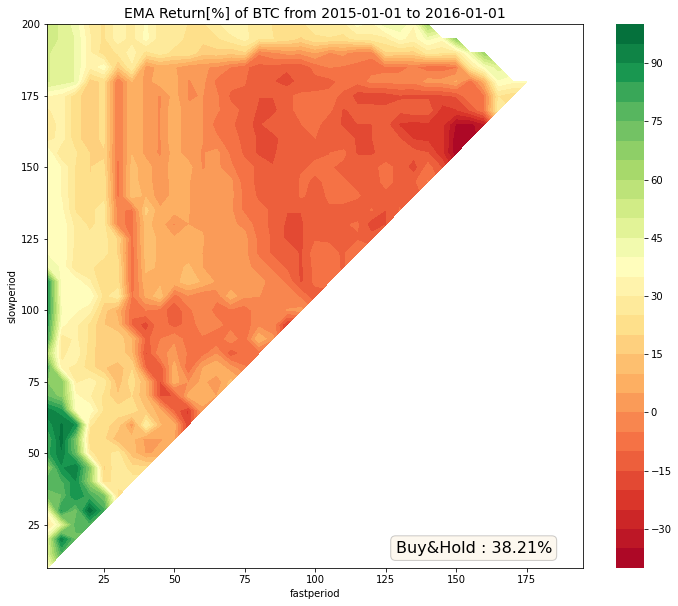

In [14]:
#@title 2015-01-01 to 2016-01-01 (1yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2016-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

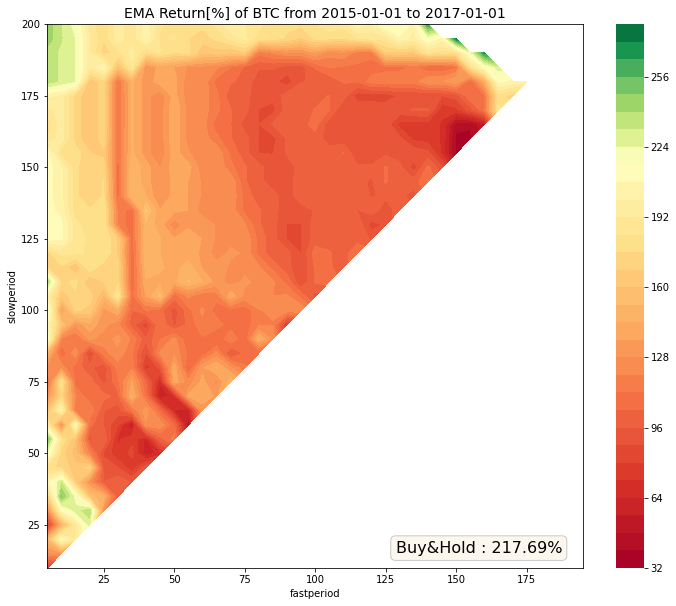

In [16]:
#@title 2015-01-01 to 2017-01-01 (2yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2017-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

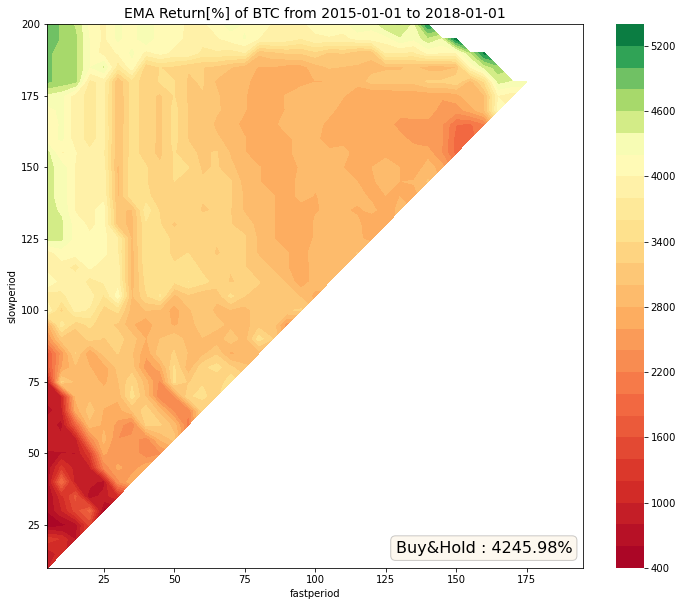

In [17]:
#@title 2015-01-01 to 2018-01-01 (3yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2018-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

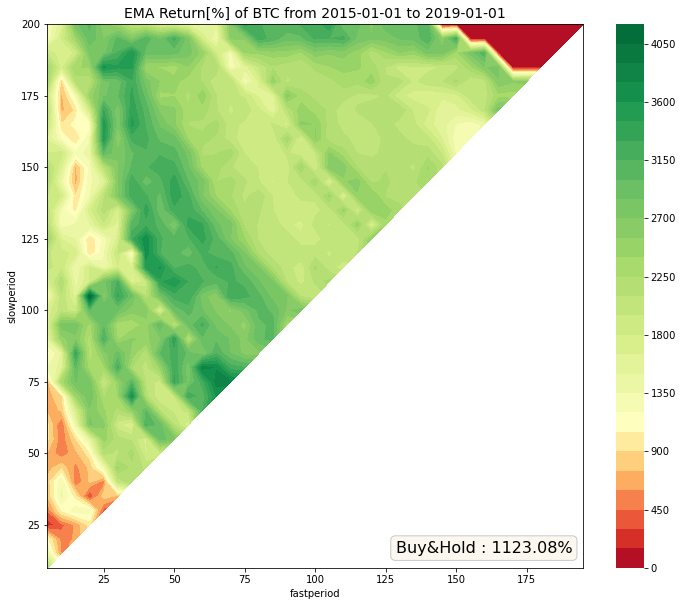

In [18]:
#@title 2015-01-01 to 2019-01-01 (4yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2019-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

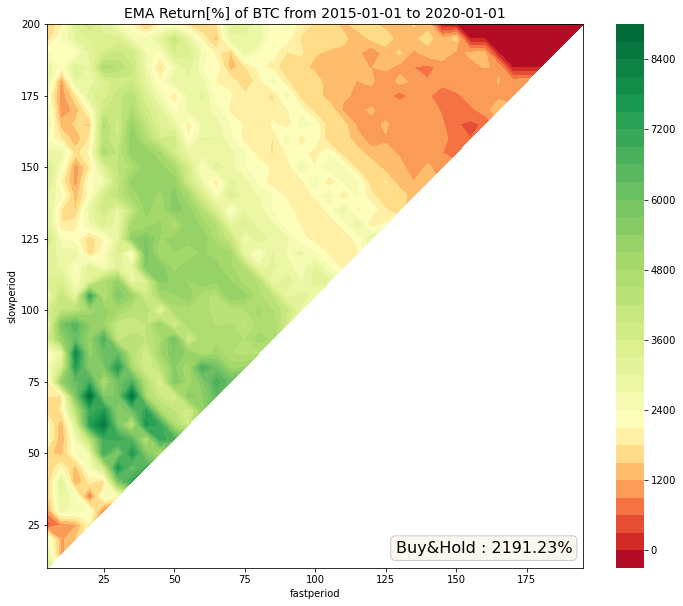

In [19]:
#@title 2015-01-01 to 2020-01-01 (5yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2020-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

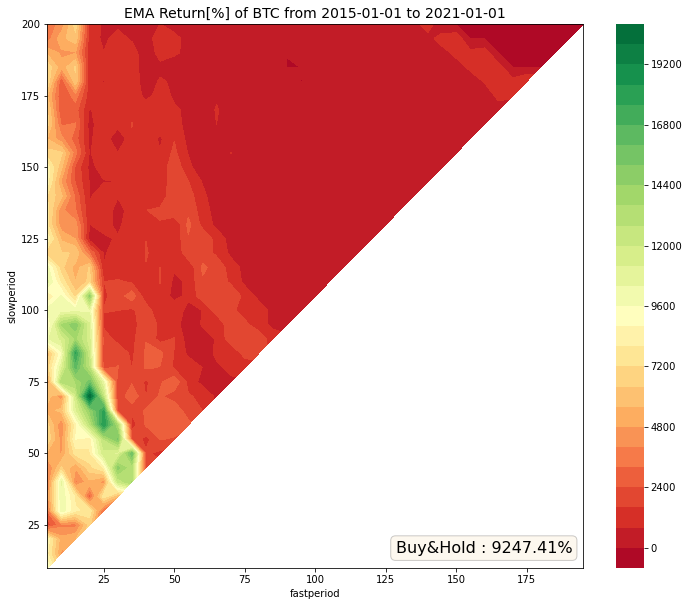

In [20]:
#@title 2015-01-01 to 2020-01-01 (6yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2021-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

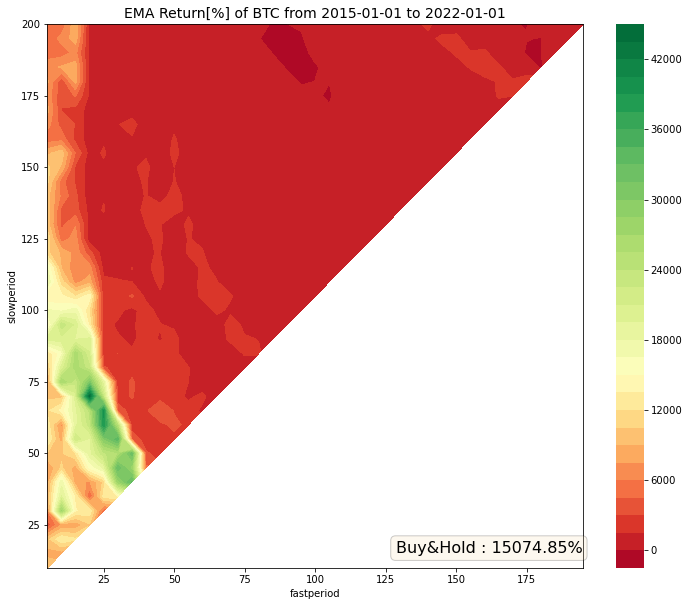

In [21]:
#@title 2015-01-01 to 2022-01-01 (7yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2022-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

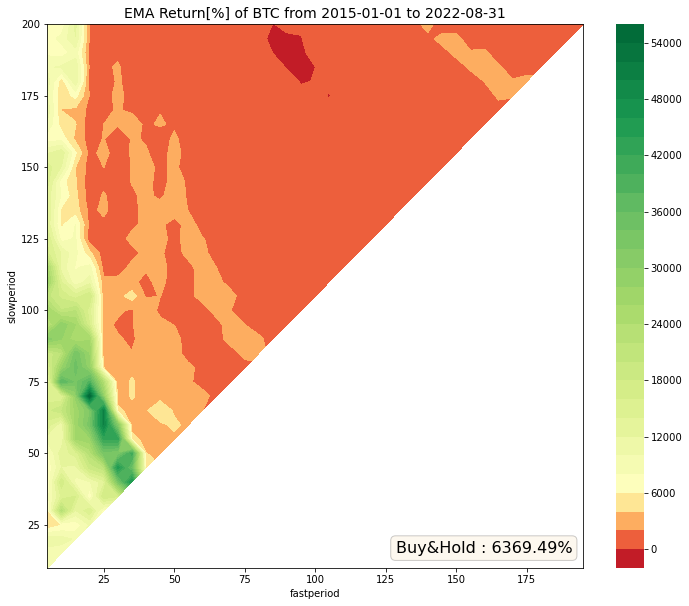

In [22]:
#@title 2015-01-01 to 2022-08-31 (7.75yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

# Fix enddate

Creating a contour plot of ROI% from trading BTC with EMA cross strategy (all in both on direction of signal) with different fast and slow period of EMA. The constraint of the backtesting is as follow:
* Initial capital : 1,000,000$
* Commission rate : 0.1%
---
<font color='green'> Green </font> = Strategy Return - Hold Return > 0 | Return of using this trading strategy is greater than Buy&Hold 

<font color='yellow'> Yellow </font>= Strategy Return - Hold Return ~ 0 | Return of this using trading strategy is equal to Buy&Hold 

<font color='red'>  Red </font> = Strategy Return - Hold Return < 0 | Return of using this trading strategy is less than Buy&Hold



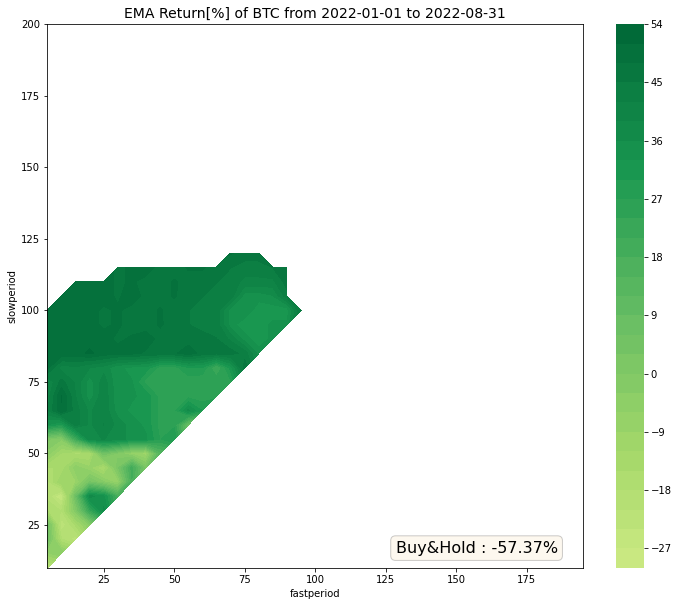

In [23]:
#@title 2022-01-01 to 2022-08-31 (0.75yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2022-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

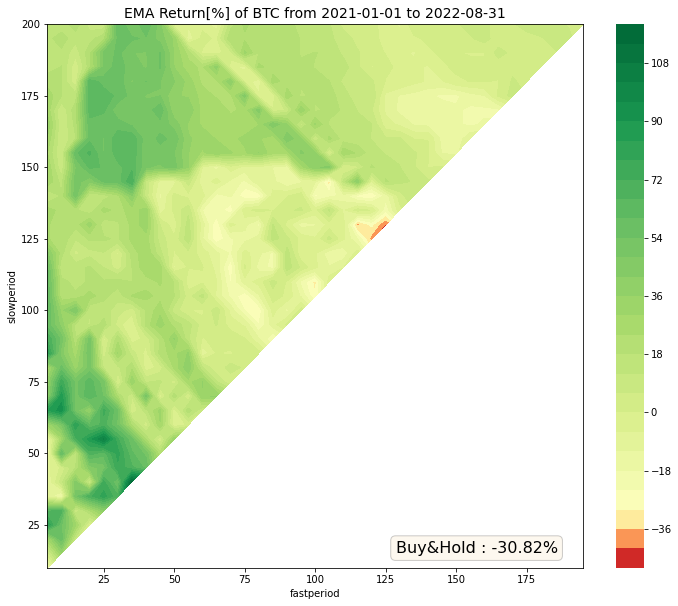

In [24]:
#@title 2021-01-01 to 2022-08-31 (1.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2021-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

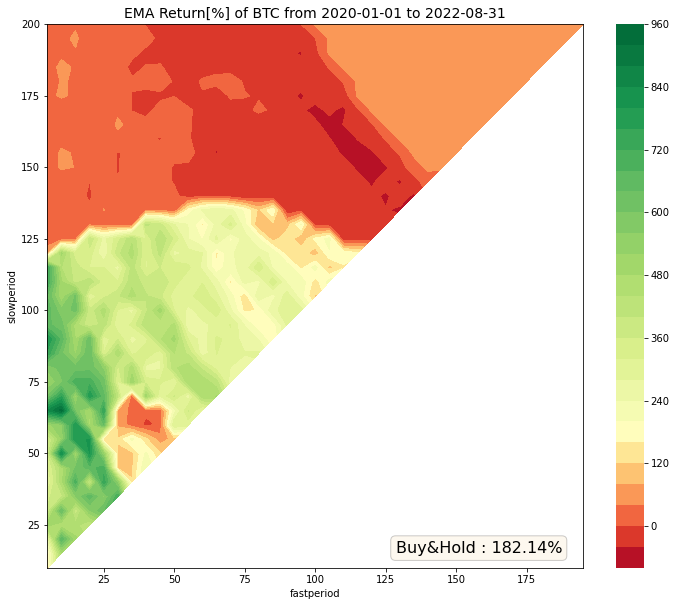

In [25]:
#@title 2020-01-01 to 2022-08-31 (2.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2020-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

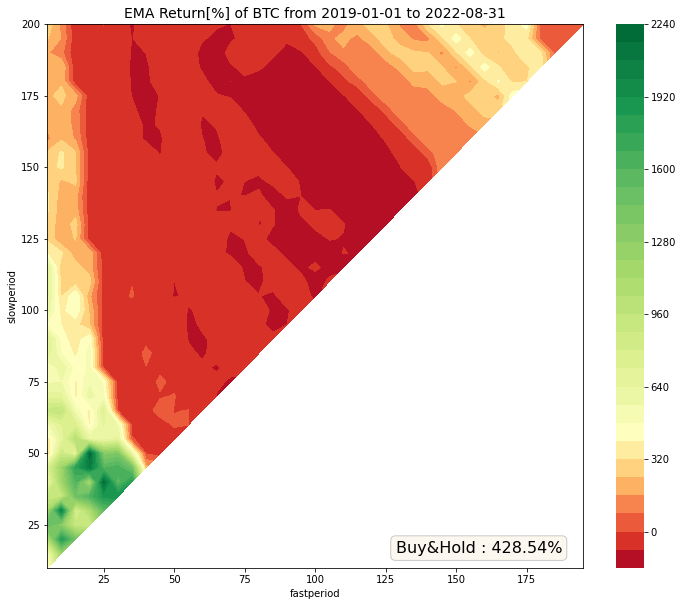

In [26]:
#@title 2019-01-01 to 2022-08-31 (3.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2019-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

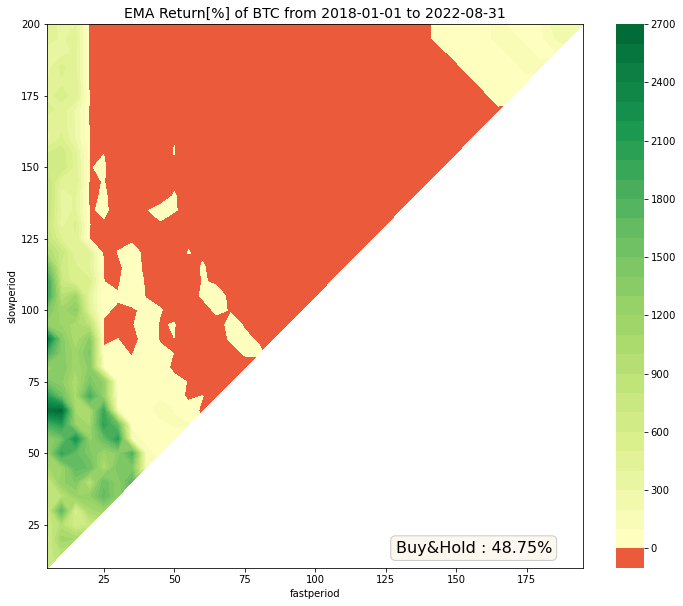

In [27]:
#@title 2018-01-01 to 2022-08-31 (4.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2018-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

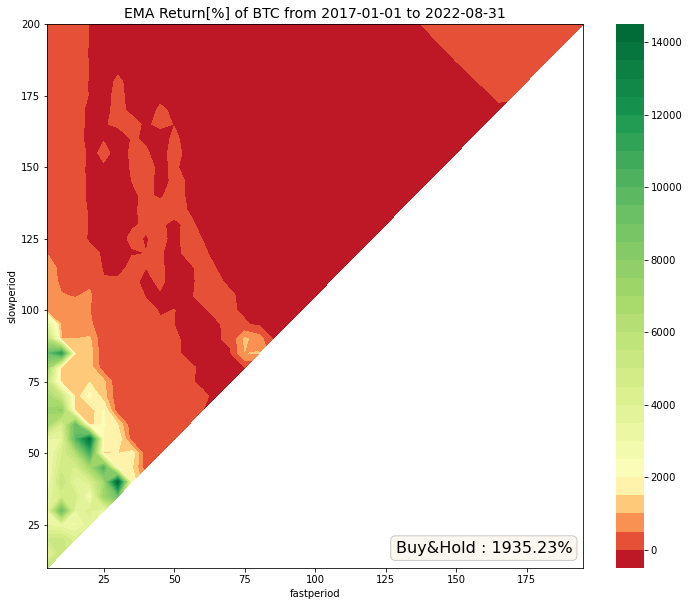

In [29]:
#@title 2017-01-01 to 2022-08-31 (5.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2017-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

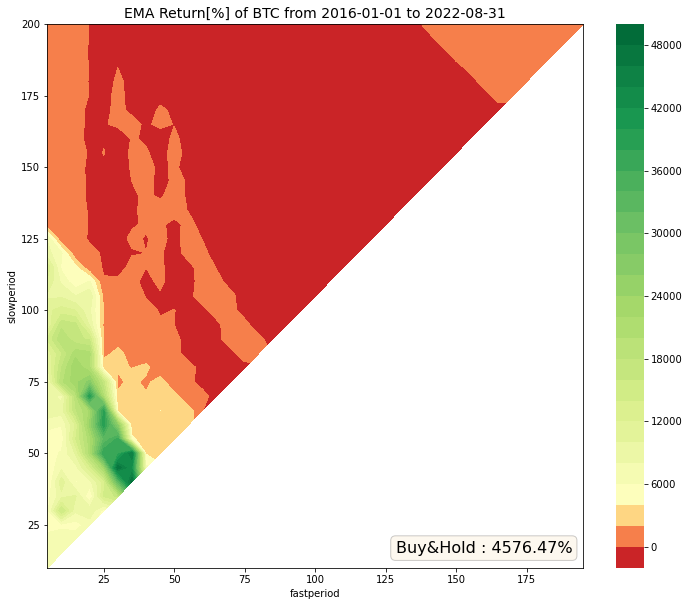

In [30]:
#@title 2016-01-01 to 2022-08-31 (6.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2016-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

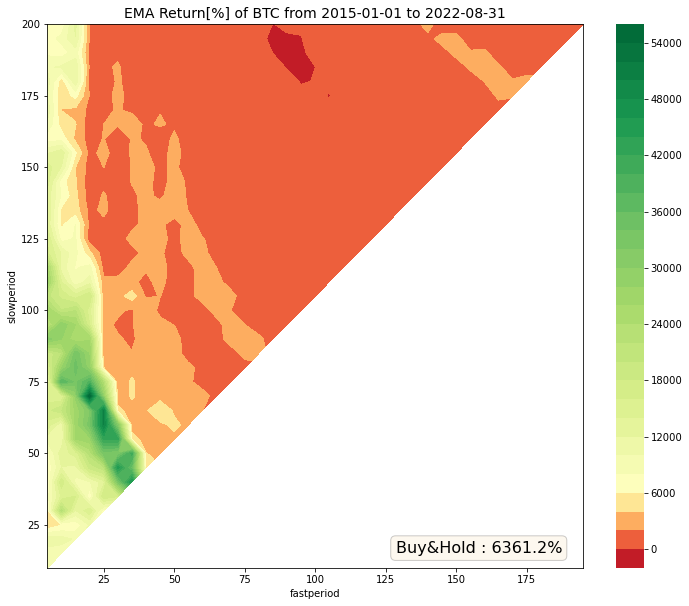

In [31]:
#@title 2015-01-01 to 2022-08-31 (7.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2015-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

,Close,High,Low,Open
t,,,,
2012-03-29,4.756541,4.820000,4.340,4.800686
2012-03-30,4.859142,4.869415,4.520,4.747252
2012-03-31,4.894393,4.921861,4.522,4.847964
2012-04-01,4.820705,4.918570,4.520,4.880020
2012-04-02,4.980836,5.010214,4.470,4.782070


D:\GitHub\backtesting.py_FL\backtesting\backtesting.py:1520: UserWarning: Searching for best of 780 configurations.
  output = _optimize_grid()


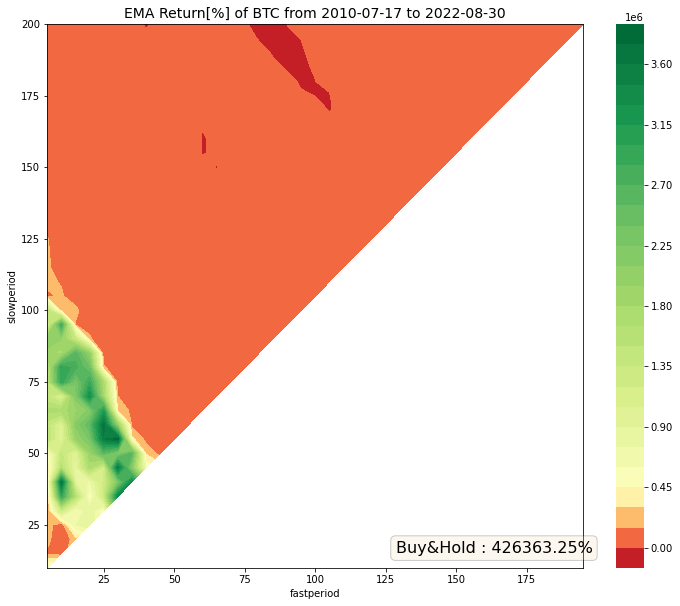

In [89]:
#@title 2012-03-30 to 2022-08-31 (10yrs)
import time
import datetime

def str_to_unix(strtime):
  return int(time.mktime(datetime.datetime.strptime(strtime, '%d/%m/%y %H:%M:%S').timetuple()))

params = {'a': 'BTC', 's':str_to_unix('30/03/12 00:00:00'), 'u':str_to_unix('31/08/22 00:00:00'), 'i':'24h', 'api_key': '2DTcBg9x0YgVPwieR9fybZAlGoA'}
read_data = pd.read_json(requests.get("https://api.glassnode.com/v1/metrics/market/price_usd_ohlc",params=params).text, convert_dates=['t']).set_index('t')
df = pd.DataFrame([[data['c'],data['h'],data['l'],data['o']] for data in read_data['o'].values],columns=['Close','High','Low','Open'],index=read_data.index)
display(df.head())
bt = Backtest(df, EMA_Cross, cash=1000000, commission=0.001)
eval_str = "bt.optimize("+opt_param_dict_to_eval_str(param,constraint)+",method=\"grid\",maximize=\"Return [%]\",return_heatmap=True)"
output = eval(eval_str)

#Output
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from 2010-07-17 to 2022-08-30'
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

,Close,High,Low,Open
t,,,,
2010-07-17,0.049510,0.04951,0.04951,0.04951
2010-07-18,0.085840,0.08585,0.05941,0.05941
2010-07-19,0.080800,0.09307,0.07855,0.09090
2010-07-20,0.074733,0.08181,0.07426,0.08181
2010-07-21,0.079210,0.07921,0.06634,0.07425


D:\GitHub\backtesting.py_FL\backtesting\backtesting.py:1520: UserWarning: Searching for best of 780 configurations.
  output = _optimize_grid()


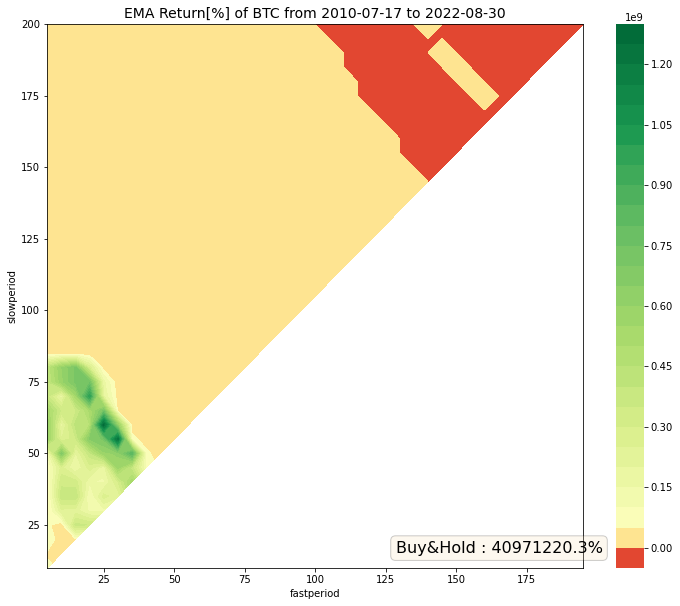

In [90]:
#@title 2010-07-17 to 2022-08-30 (12yrs)
import time
import datetime

def str_to_unix(strtime):
  return int(time.mktime(datetime.datetime.strptime(strtime, '%d/%m/%y %H:%M:%S').timetuple()))

params = {'a': 'BTC', 's':str_to_unix('17/07/10 00:00:00'), 'u':str_to_unix('31/08/22 00:00:00'), 'i':'24h', 'api_key': '2DTcBg9x0YgVPwieR9fybZAlGoA'}
read_data = pd.read_json(requests.get("https://api.glassnode.com/v1/metrics/market/price_usd_ohlc",params=params).text, convert_dates=['t']).set_index('t')
df = pd.DataFrame([[data['c'],data['h'],data['l'],data['o']] for data in read_data['o'].values],columns=['Close','High','Low','Open'],index=read_data.index)
display(df.head())
bt = Backtest(df, EMA_Cross, cash=1000000, commission=0.001)
eval_str = "bt.optimize("+opt_param_dict_to_eval_str(param,constraint)+",method=\"grid\",maximize=\"Return [%]\",return_heatmap=True)"
output = eval(eval_str)

#Output
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from 2010-07-17 to 2022-08-30'
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

# Bubble

Creating a contour plot of ROI% from trading BTC with EMA cross strategy (all in both on direction of signal) with different fast and slow period of EMA. The constraint of the backtesting is as follow:
* Initial capital : 1,000,000$
* Commission rate : 0.1%
---
<font color='green'> Green </font> = Strategy Return - Hold Return > 0 | Return of using this trading strategy is greater than Buy&Hold 

<font color='yellow'> Yellow </font>= Strategy Return - Hold Return ~ 0 | Return of this using trading strategy is equal to Buy&Hold 

<font color='red'>  Red </font> = Strategy Return - Hold Return < 0 | Return of using this trading strategy is less than Buy&Hold



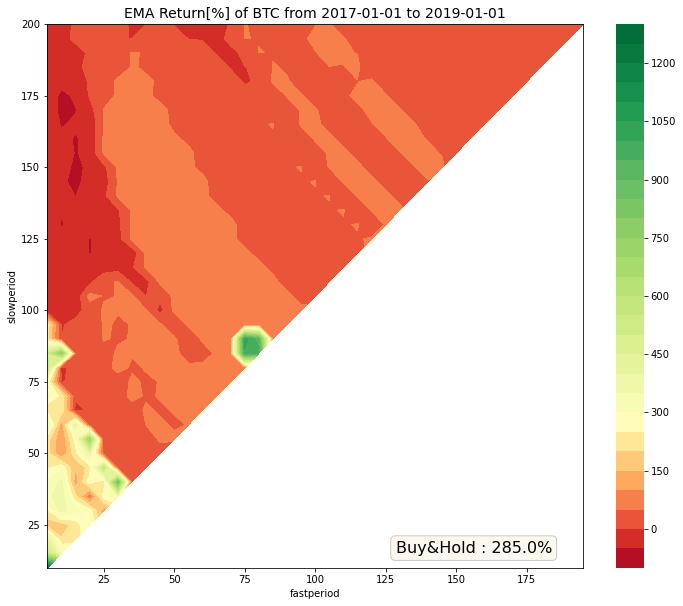

In [32]:
#@title 2017 boom and 2018 crash [2017-01-01 to 2019-01-01] (2yrs) 
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2017-01-01" 
end_date = "2019-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

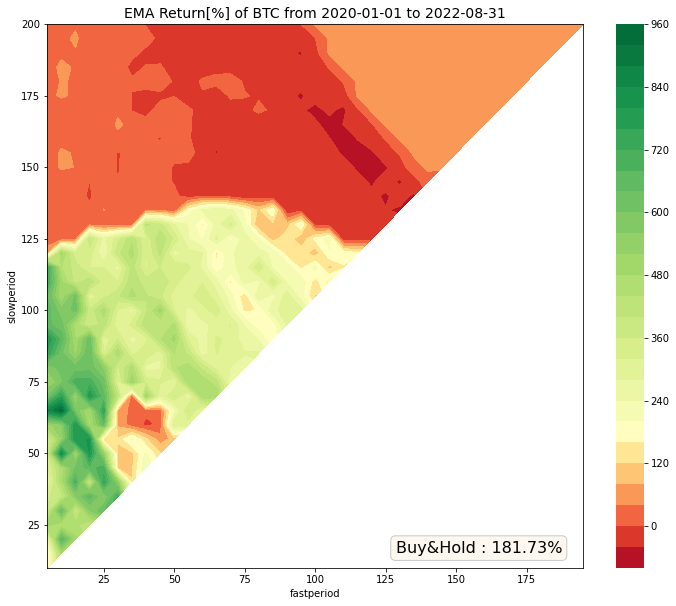

In [33]:
#@title 2020-21 boom and 2021-2022 crash [2020-01-01 to 2022-08-31] (2.75yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2020-01-01" 
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

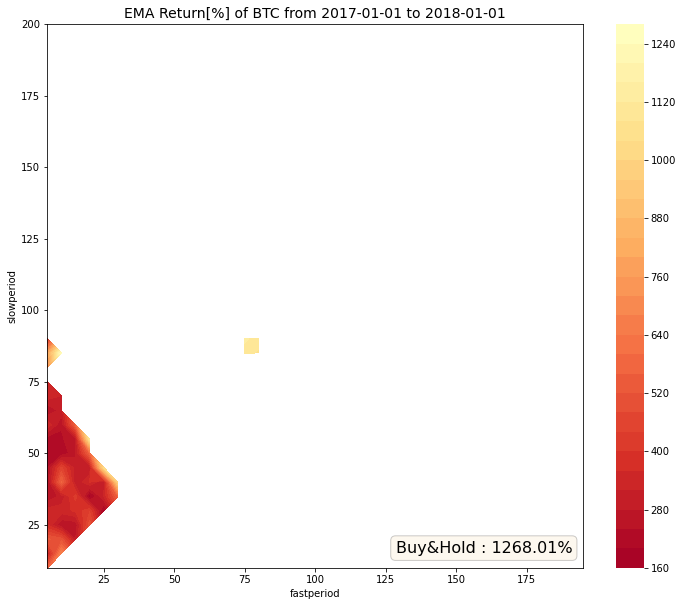

In [38]:
#@title 2017 boom [2017-01-01 to 2018-01-01] (1yrs) 
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2017-01-01" 
end_date = "2018-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

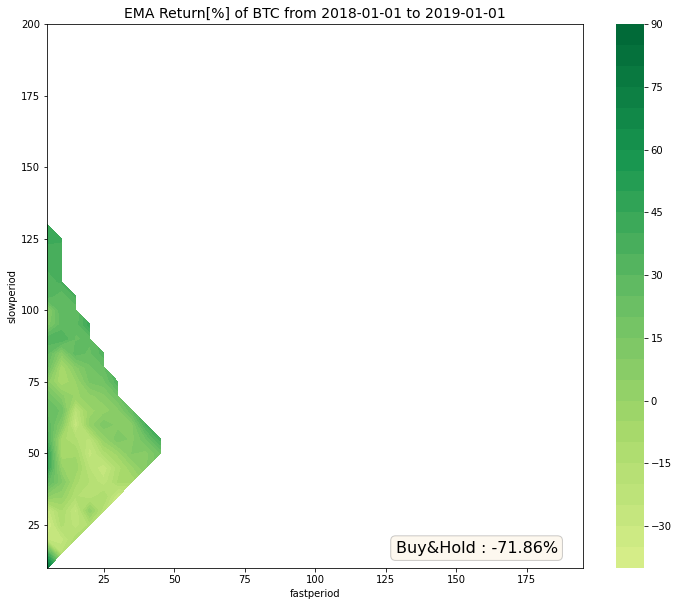

In [39]:
#@title 2018 crash [2018-01-01 to 2019-01-01] (1yrs) 
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2018-01-01" 
end_date = "2019-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

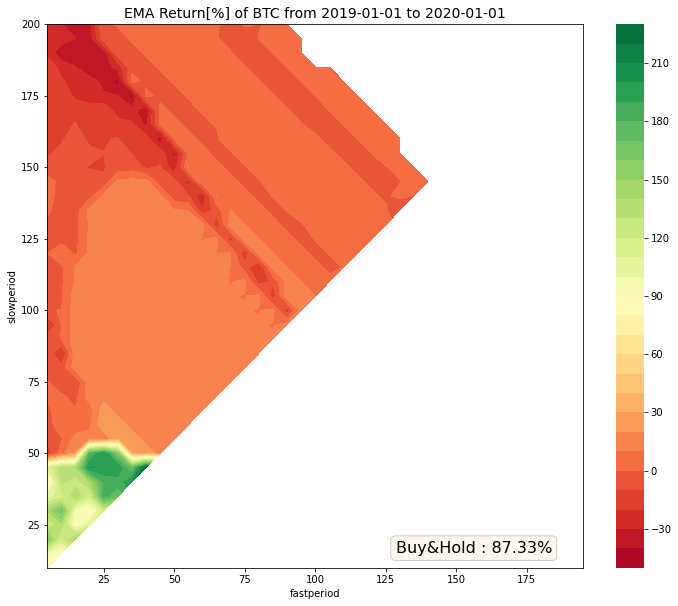

In [40]:
#@title 2019 [2019-01-01 to 2020-01-01] (1yrs) 
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2019-01-01" 
end_date = "2020-01-01"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

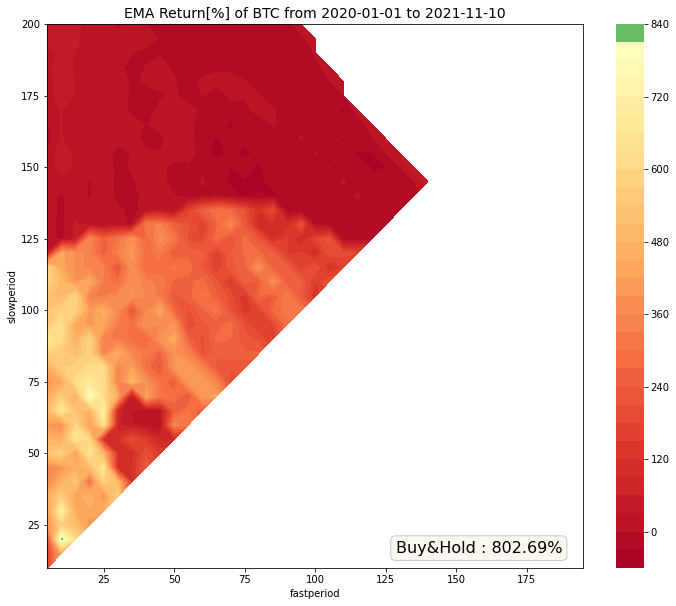

In [36]:
#@title 2020-21 boom [2020-01-01 to 2021-11-10] (1.9yrs)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2020-01-01" 
end_date = "2021-11-10"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()

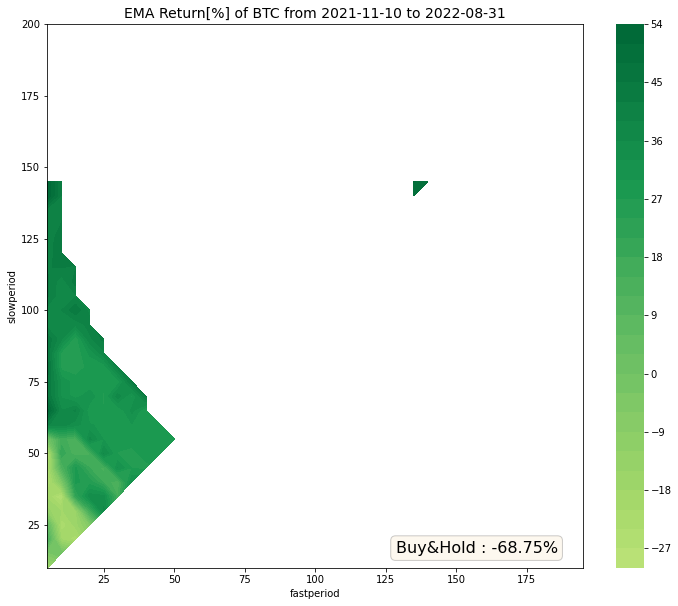

In [37]:
#@title 2021-22 crash [2021-11-10 to 2022-08-31] (0.8yr)
## Input ##
strategy = EMA_Cross
ticker = "BTC-USD"
start_date = "2021-11-10"  
end_date = "2022-08-31"  
param = {'param_fastperiod':list(np.arange(5,205,5)), 'param_slowperiod':list(np.arange(5,205,5))}
constraint = 'param_fastperiod < param_slowperiod'
bt, output = Test_Strategy(ticker,strategy,param=param,constraint=constraint,start_date=start_date,end_date=end_date,
                           cash=1000000,commission=.001,plot=False,optimize=True,optimize_method='grid',maximize='Return [%]')
clear_output()
## Output ##
output_df = pd.DataFrame(output[0]).T.iloc[:,:-3]
hold_return = output_df['Buy & Hold Return [%]'].values[0]
hdf = output[1]
hdfreset = hdf.reset_index()
hdfreset.columns = ['a', 'b', 'values']
hdfpivot=hdfreset.pivot('a', 'b')
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(12,10))
ax = plt.gca()
divnorm=colors.TwoSlopeNorm(vcenter=hold_return)
plt.contourf(Yi, Xi, Z,levels=30, cmap='RdYlGn', norm=divnorm);
plt.xlabel('fastperiod')
plt.ylabel('slowperiod')
title = 'EMA Return[%] of BTC from ' + start_date +' to ' + end_date
plt.title(title,fontsize=14)
cbar = plt.colorbar()
cbar.outline.set_visible(False)
textstr = 'Buy&Hold : '+ str(np.round(hold_return,2))+'%'
ax.text(0.65, 0.05, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
plt.show()